1. Escribe una función que descargue automáticamente el fichero de datos con medidas mensuales de la URL https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2/co2_mm_mlo.txt y que lo convierta a un formato numérico (dataframe, numpy arrays, etc.).

In [1]:
import requests
import os
import numpy as np

from sklearn import datasets, svm

In [2]:
def get_files(url):
    directorio=os.getcwd()

    response = requests.get('https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2/co2_mm_mlo.txt')
    if response.status_code == 200:
        with open(directorio + "\\co2_mm_mlo.txt", 'wb') as f:
            f.write(response.content)
            
url = 'https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2/co2_mm_mlo.txt'           
get_files(url)

In [3]:
import pandas as pd
df = pd.read_table(".\co2_mm_mlo.txt", skiprows=52, sep='\s+')

In [4]:
df.columns = ['date','month','dec.date','mon.avg','de-season-ali','days','st.dev.of.days','unc.of.mon.mean']

In [5]:
df.head()

,date,month,dec.date,mon.avg,de-season-ali,days,st.dev.of.days,unc.of.mon.mean
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


2. Obten las variables months y avg_ppmvs.

In [6]:
year = df['date']
months = df['month'] #variable month
month_dec = year + (months-1)/12 #variable month in decimal
avg_ppmvs = df['mon.avg']
dec_date = df['dec.date']

3. Comprueba si los datos coinciden con los datos usados en la práctica (devueltos por load_mauna_loa_atmospheric_co2()) para las fechas en que existen datos en ambos conjuntos.

`Voy a graficar ambos conjuntos de datos para comprobar que coinciden para el rango de fechas 1958-2001.`

In [7]:
from sklearn.datasets import fetch_openml

In [8]:
# Convierto la variable month a decimal(yr+(m-1/12)) y calculo el promedio por mes usando la función definida 
#en la práctica.
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187, cache=False)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data['year']
    m = ml_data.data['month']
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

X, y = load_mauna_loa_atmospheric_co2()

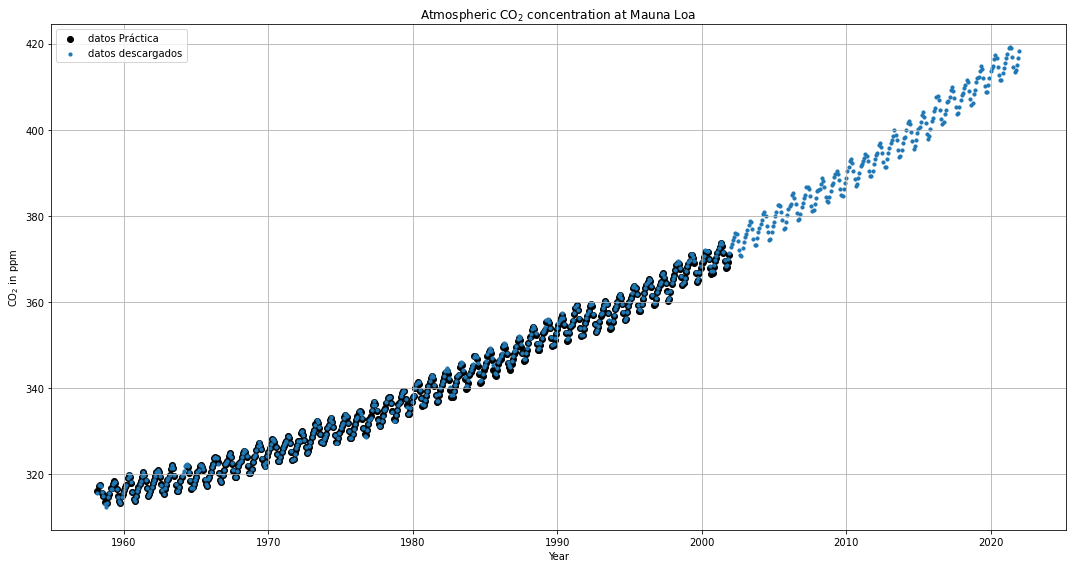

In [10]:
#grafico ambos conjuntos de datos
import matplotlib.pyplot as plt

# Illustration
fig = plt.figure(figsize=(15,8))
data1=plt.scatter(X, y, c='k',label='datos Práctica')
data2=plt.scatter(month_dec,avg_ppmvs,s=10,label='datos descargados')
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.legend(handles=[data1, data2])
plt.show()

`Efectivamente los valores coinciden para las fechas en las que existen datos en ambos conjuntos.`

4. Busca los mejores hiperparámetros del GP para predecir la serie temporal del CO2 usando datos hasta la fecha más reciente. Compara estos hiperparámetros con los que se encontraron al usar datos hasta diciembre de 2001 (los datos usados en la práctica).

`Siguiendo la práctica usaré un Kernel que tiene varios términos: K=k1+k1+k1+k4`
- K1: Una "squared exponential" para modelizar la tendencia creciente que muestran los datos a largo plazo. Este término tiene dos parámetros a ajustar.
- K2: Una "Squared exponential" multiplicada por una "Exponential sin Squared" paramodelizar el comportamiento periódico estacional. Este término posee tres parámetros a ajustar.
- K3: Un término "rational quadratic" para modelizar irregularidades en un mediano plazo. Este término posee 3 parámetros a ajustar.
- K4: Finalmente un término "white noise" que es la suma de una "squared exponential y y una contribución independiente". Este término tiene tres parámetros a ajustar.

`Por consiguiente nuestro kernel tiene 11 hiperparámetros a ajustar`

`Mejores hiperparámetros obtenidos mpara el GP usando los datos de la practica:`

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from time import time
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared

# Kernel with generic parameters
k1 = C(50, (1e1, 1e+3)) * RBF(50,(1e0,1e5))  # long term smooth rising trend
k2 = C(5, (1e1, 1e+2)) * RBF(100,(1e0,1e5)) \
    * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-1,1e1),
                     periodicity=1.0, periodicity_bounds="fixed")  # seasonal component
k3 = C(0.5, (1e-2, 1e1)) * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-2,1e3),
                                alpha=1.0, alpha_bounds=(1e-1,1e3)) # medium term irregularities
k4 = C(0.1, (1e-3, 1e+1)) * RBF(0.1,(1e-2,1e2)) \
    + WhiteKernel(noise_level=0.1**2,noise_level_bounds=(1e-4, 1e0)) # noise terms
kernel = k1 + k2 + k3 + k4

# Fit the Gaussian Process regressor, and optimize the hyperparameters
gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True,
                              n_restarts_optimizer=1,
                              random_state=2)
t0 = time()
gp.fit(X, y)
print("Elapsed time: %0.3fs"%(time() - t0))

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

C:\Users\Ana\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Ana\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Ana\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Ana\anaconda3\lib\site-packages\sklearn\gaussian_process\ker

Elapsed time: 24.127s

Learned kernel: 3.33**2 * RBF(length_scale=58.1) + 3.16**2 * RBF(length_scale=870) * ExpSineSquared(length_scale=3.47, periodicity=1) + 0.1**2 * RationalQuadratic(alpha=0.1, length_scale=9.64) + 0.0316**2 * RBF(length_scale=0.408) + WhiteKernel(noise_level=0.000172)
Log-marginal-likelihood: 1327.268


`Para ver que tan buena ha sido la predicción hecha para los datos usados en la práctica, grafico el modelo obtenido en la practica junto con los datos más recientes:`

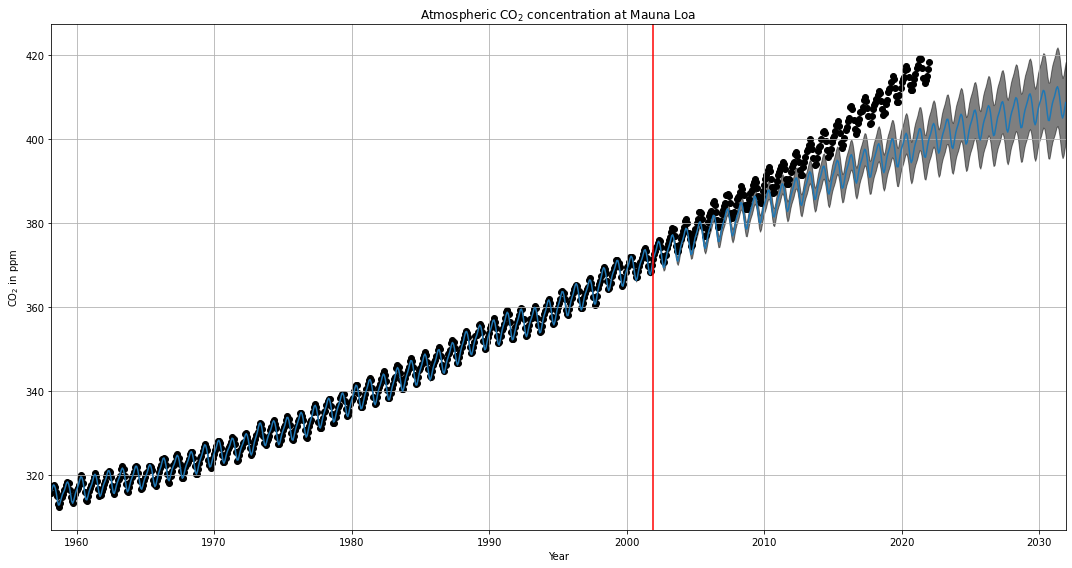

In [13]:
# plot the prediction
fig = plt.figure(figsize=(15,8))
plt.scatter(month_dec,avg_ppmvs, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.grid(True)
plt.axvline(x=2001+11/12, color='r')
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

`En la figura anterior la línea roja muestra donde terminaba la serie temporal de los datos de la práctica. Podemos ver que a partir del año ~2005 la prediccion se empieza a separar de los datos, la pendiente del término creciente de  largo plazo ha sido subestimada por el modelo. Por otro lado el término peiódico estacional parece mantenerse sin grandes variaciones.`

`Entonces podemos decir que el modelo ha predicho correctamente los siguientes ~4 años.` 

`Ahora buscaré los mejores hiperparámetros del GP usando los datos más recientes:`

In [184]:
X2 = np.array(month_dec).reshape(-1, 1)
y2 = np.array(avg_ppmvs)


# Kernel with generic parameters
k1 = C(50, (1e1, 1e+3)) * RBF(50,(1e0,1e5))  # long term smooth rising trend
k2 = C(5, (1e1, 1e+2)) * RBF(100,(1e0,1e5)) \
    * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-1,1e1),
                     periodicity=1.0, periodicity_bounds="fixed")  # seasonal component
k3 = C(0.5, (1e-2, 1e1)) * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-2,1e3),
                                alpha=1.0, alpha_bounds=(1e-1,1e3)) # medium term irregularities
k4 = C(0.1, (1e-3, 1e+1)) * RBF(0.1,(1e-2,1e2)) \
    + WhiteKernel(noise_level=0.1**2,noise_level_bounds=(1e-4, 1e0)) # noise terms
kernel = k1 + k2 + k3 + k4

# Fit the Gaussian Process regressor, and optimize the hyperparameters
gp2 = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True,
                              n_restarts_optimizer=1,
                              random_state=2)
t0 = time()
gp2.fit(X2, y2)
print("Elapsed time: %0.3fs"%(time() - t0))

print("\nLearned kernel: %s" % gp2.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X2_ = np.linspace(X2.min(), X2.max() + 30, 1000)[:, np.newaxis]
y2_pred, y2_std = gp2.predict(X2_, return_std=True)

C:\Users\Ana\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Ana\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Ana\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Ana\anaconda3\lib\site-packages\sklearn\gaussian_process\ker

Elapsed time: 63.119s

Learned kernel: 5.15**2 * RBF(length_scale=104) + 3.16**2 * RBF(length_scale=342) * ExpSineSquared(length_scale=7.66, periodicity=1) + 0.1**2 * RationalQuadratic(alpha=0.1, length_scale=3.31) + 0.282**2 * RBF(length_scale=88.4) + WhiteKernel(noise_level=0.0001)
Log-marginal-likelihood: 1327.268


## Comparación de los hiperparámetros obtenidos con ambos modelos:

In [151]:
print("\nLearned kernel datos practica: %s" % gp.kernel_)
print("\nLearned kernel datos descargados: %s" % gp2.kernel_)


Learned kernel datos practica: 3.33**2 * RBF(length_scale=58.1) + 3.16**2 * RBF(length_scale=870) * ExpSineSquared(length_scale=3.47, periodicity=1) + 0.1**2 * RationalQuadratic(alpha=0.1, length_scale=9.64) + 0.0316**2 * RBF(length_scale=0.408) + WhiteKernel(noise_level=0.000172)

Learned kernel datos descargados: 5.15**2 * RBF(length_scale=104) + 3.16**2 * RBF(length_scale=342) * ExpSineSquared(length_scale=7.66, periodicity=1) + 0.1**2 * RationalQuadratic(alpha=0.1, length_scale=3.31) + 0.282**2 * RBF(length_scale=88.4) + WhiteKernel(noise_level=0.0001)


In [156]:
print("Log-marginal-likelihood datos practica: %.3f"
      % 1327.268)
print("Log-marginal-likelihood datos descargados: %.3f"
      % 2341.942)

Log-marginal-likelihood datos practica: 1327.268
Log-marginal-likelihood datos descargados: 2341.942


`Parámetros obtenidos para el "long term Kernel" K1`
- La "length scale" ha aumentado de ~58 yr a ~104 yr. Lo cual tiene sentido porque hemos agregado más datos, lo que hace que el modelo sea menos flexible. 
- La magnitud tambien ha aumentado de 3.33 a 5.15 ppm, lo cual tambien tiene sentido debido a la tendencia creciente del long term, al agregar datos mas acutales este valor ha incrementado.

` Parámetros obtenidos para el "seasonal term Kernel" K2`
- La magnitud no ha variado.
- El tiempo de decaimiento ha disminuido de 870 a 342 yr, de todas formas estos valores tan altos para el decaimiento indican que los datos siguen teniendo un comportamiento cercano al periódico en una escala termporal estacional.
- La "length scale" de la componente periodica ha subido de 4.47 yr a 7.66 yr, lo cual indica que esta componente se ha "suavizado".

` Parámetros obtenidos para el "short term Kernel" K3`
- La magnitud no ha variado.
- La escala ha disminuido de 9.64 yrs a 3.31 yrs, lo cual indica que este termino se ha hecho más flexible, o menos suave. Podríamos decir que los nuevos datos introducen más variaciones a corto plazo.
- El termino alfa que determina la forma del decaimiento de este término no ha variado. 

` Parámetros obtenidos para el "Correlated Noise Kernel" K4-a`
- La "length scale" de este término ha aumentado considerablemente de 0.408 a 88.4.
- La magnitud ha incrementado de 0.0316 a 0.282. Al haber agregado más datos, y el modelo ser menos flexible (mayor "length scale"), la componente de ruido aumenta. 

` Parámetros obtenidos para el "White Noise Kernel"K4-b`
- La magnitud de este termino ha incrementado de 0.000172 a 0.001. Pero sigue siendo muy baja indicando que el modelo explica los datos de forma correcta. 

5. Haz una figura que muestre la serie temporal completa y una predicción de los próximos 20 años, incluso bandas de confianza.

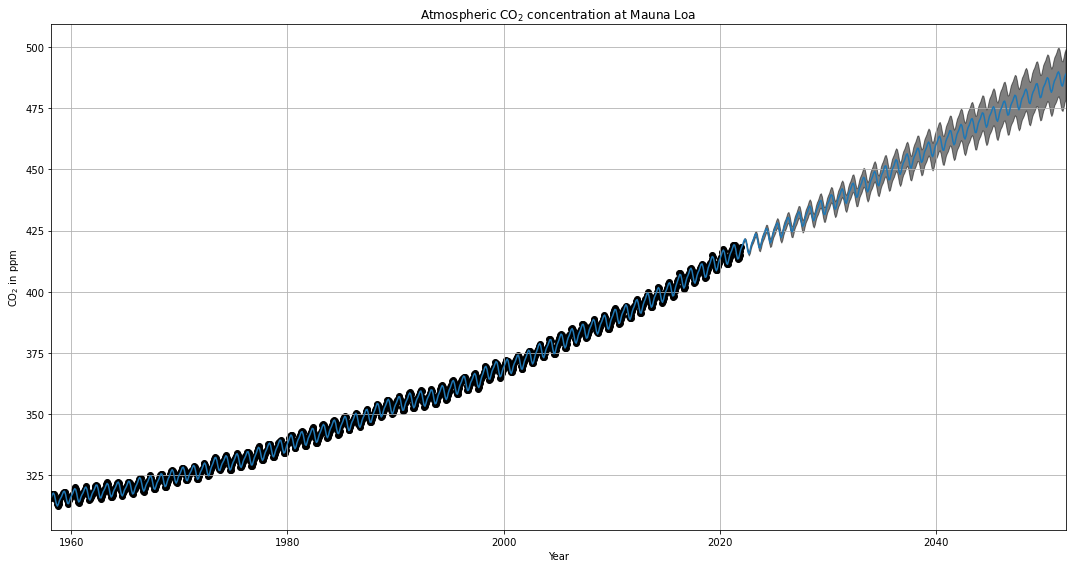

In [188]:
# plot the prediction
fig = plt.figure(figsize=(15,8))
plt.scatter(month_dec,avg_ppmvs, c='k')
plt.plot(X2_, y2_pred)
plt.fill_between(X2_[:, 0], y2_pred-y2_std, y2_pred+y2_std,
                 alpha=0.5, color='k')
plt.xlim(X2_.min(), X2_.max())
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

`En la anterior figura muestro el ajuste hecho para la serie temporal completa y una predicción a más de 20 años.`